In [1]:
import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
import os
import time
import random

In [2]:
from BaselineSolver import BaselineSolver
from IterativeSolver import IterativeSolver
from GreedySolver import GreedySolver
from GradientDescentSolver import GradientDescentSolver
from utils import run_tests, read_tests_simplex_in_ball, run_random_test, read_tests_simplex_plus_ball_in_ball
from utils import read_tests_degenerate_simplex_in_ball, read_tests_polyhedron_in_ball, read_tests_simplex_in_ball_with_argmaxes

In [3]:
support_a, support_b = read_tests_simplex_in_ball_with_argmaxes(f'./tests/3d/simplex-in-ball/16', 3)
solver_instance = GradientDescentSolver(3, support_a, support_b, max_num_iterations=100, learning_rate=1)
solver_instance.solve()

In [4]:
def plot_test_results(times: np.ndarray, t_errors: np.ndarray, title: str, colors: tp.Optional[np.ndarray] = None, fit=True, colorbar_name='delta') -> None:
    t_errors_without_zeros = np.copy(t_errors)
    t_errors_without_zeros[t_errors_without_zeros == 0.] = 1e-16
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    plt.xlabel('time, s')
    plt.ylabel('t_error')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    if colors is not None:
        plt.scatter(times, t_errors_without_zeros, c=colors, cmap='viridis_r', norm=LogNorm())
        plt.colorbar(label=colorbar_name)
    else:
        plt.scatter(times, t_errors_without_zeros)

    if fit:
        a, b = np.polyfit(np.log(times), np.log(t_errors_without_zeros), 1)
        plt.plot(times, np.exp(a * np.log(times) + b), 'r', label=f't_error ~ 1 / time^{-a:.2f}')
        plt.legend()
    plt.title(title)
    plt.savefig(f'figures/{title.replace(" ", "_").replace(",", "")}')

In [5]:
def get_gd_simplex_in_ball_results(dimension: int, silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b = read_tests_simplex_in_ball_with_argmaxes(f'./tests/{dimension}d/simplex-in-ball/{file}', dimension)
        solver_instance = GradientDescentSolver(dimension, support_a, support_b, max_num_iterations=1000, learning_rate=1)
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        if not silent:
            print(f'test {file}\t time {end_time - start_time}\t t_error {abs(1. - solver_instance.t)}\t num_iterations {solver_instance.iteration}')

    return np.array(times), np.array(t_errors)

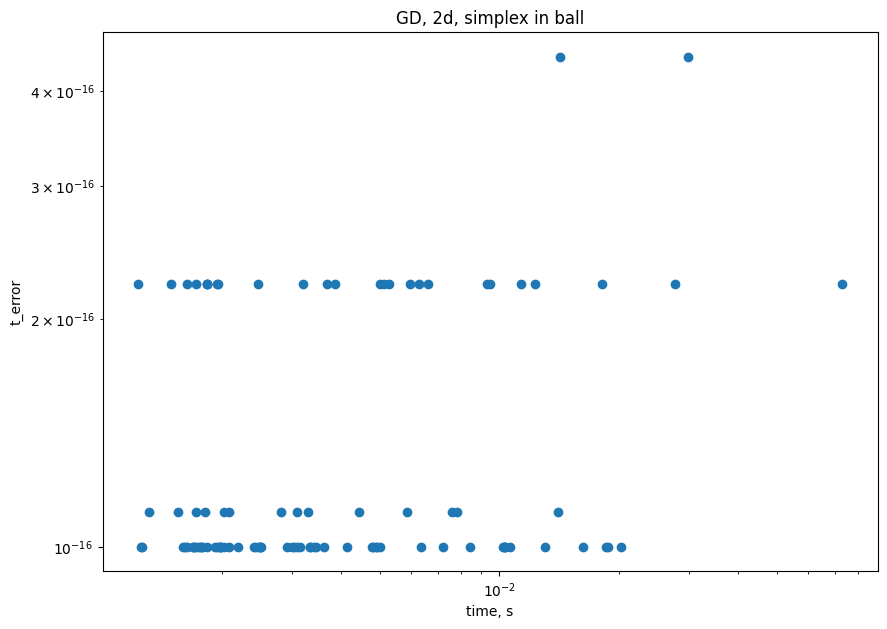

In [6]:
times_gd_2d, errors_gd_2d = get_gd_simplex_in_ball_results(2, silent=True)
plot_test_results(times_gd_2d, errors_gd_2d, 'GD, 2d, simplex in ball', fit=False)

test 1	 time 0.008928060531616211	 t_error 0.0	 num_iterations 5
test 10	 time 0.05590081214904785	 t_error 0.0	 num_iterations 24
test 100	 time 0.005650758743286133	 t_error 0.0	 num_iterations 5
test 11	 time 0.024374008178710938	 t_error 0.0	 num_iterations 17
test 12	 time 0.0073359012603759766	 t_error 0.0	 num_iterations 7
test 13	 time 0.006781578063964844	 t_error 2.220446049250313e-16	 num_iterations 7
test 14	 time 0.013994455337524414	 t_error 0.0	 num_iterations 10
test 15	 time 0.002141714096069336	 t_error 0.0	 num_iterations 4
test 16	 time 0.07900834083557129	 t_error 2.220446049250313e-16	 num_iterations 47
test 17	 time 0.003830432891845703	 t_error 2.220446049250313e-16	 num_iterations 5
test 18	 time 0.002659320831298828	 t_error 2.220446049250313e-16	 num_iterations 4
test 19	 time 0.29309749603271484	 t_error 0.0	 num_iterations 170
test 2	 time 0.0075342655181884766	 t_error 2.220446049250313e-16	 num_iterations 7
test 20	 time 0.024943828582763672	 t_error 0.0	

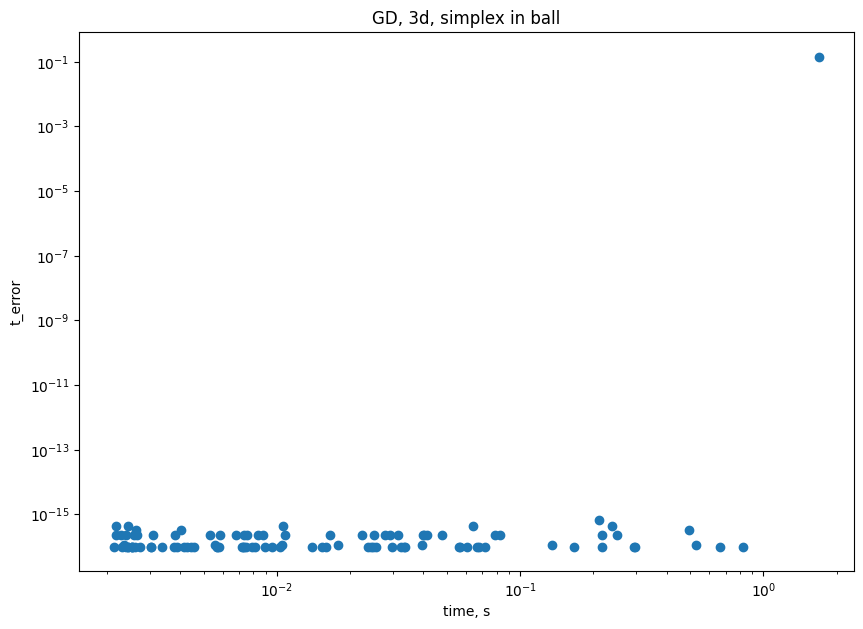

In [7]:
times_gd, errors_gd = get_gd_simplex_in_ball_results(3, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 3d, simplex in ball', fit=False)

test 1	 time 0.12332725524902344	 t_error 2.220446049250313e-16	 num_iterations 28
test 10	 time 1.972987174987793	 t_error 0.15169127151117678	 num_iterations 1000
test 100	 time 1.2752082347869873	 t_error 0.0	 num_iterations 674
test 11	 time 0.2970004081726074	 t_error 0.0	 num_iterations 133
test 12	 time 0.0671529769897461	 t_error 1.1102230246251565e-16	 num_iterations 28
test 13	 time 0.6842195987701416	 t_error 0.0	 num_iterations 333
test 14	 time 0.36414456367492676	 t_error 2.220446049250313e-16	 num_iterations 166
test 15	 time 0.012699127197265625	 t_error 0.0	 num_iterations 9
test 16	 time 0.013537406921386719	 t_error 0.0	 num_iterations 10
test 17	 time 0.50404953956604	 t_error 4.440892098500626e-16	 num_iterations 268
test 18	 time 0.8329992294311523	 t_error 0.0	 num_iterations 427
test 19	 time 0.011855602264404297	 t_error 2.220446049250313e-16	 num_iterations 8
test 2	 time 0.09185934066772461	 t_error 2.220446049250313e-16	 num_iterations 48
test 20	 time 0.004

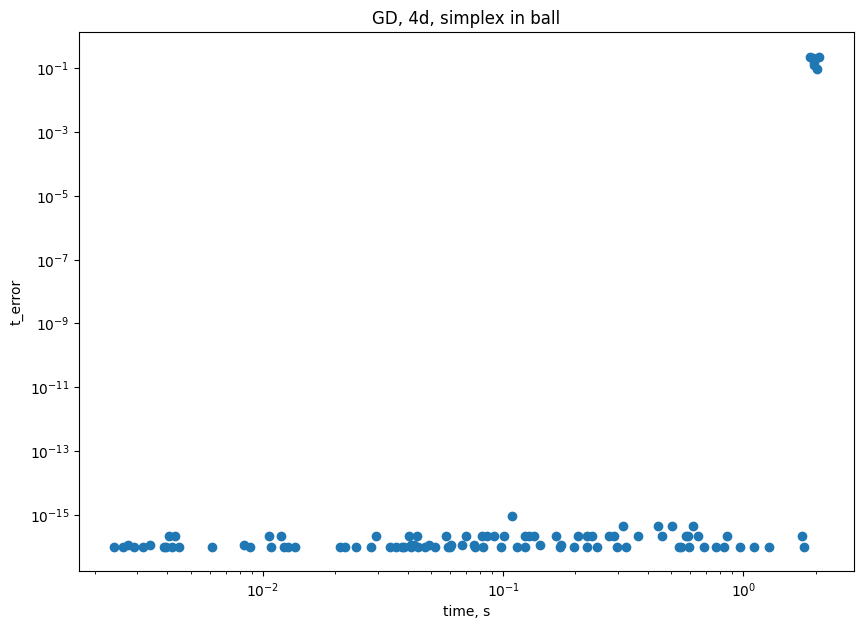

In [8]:
times_gd, errors_gd = get_gd_simplex_in_ball_results(4, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 4d, simplex in ball', fit=False)

test 1	 time 0.15381693840026855	 t_error 0.0	 num_iterations 60
test 10	 time 1.0652263164520264	 t_error 2.220446049250313e-16	 num_iterations 498
test 100	 time 0.19834518432617188	 t_error 2.220446049250313e-16	 num_iterations 97
test 11	 time 2.1332521438598633	 t_error 0.25461632068610696	 num_iterations 1000
test 12	 time 1.652209758758545	 t_error 2.220446049250313e-16	 num_iterations 761
test 13	 time 0.9775431156158447	 t_error 0.0	 num_iterations 450
test 14	 time 2.034947395324707	 t_error 1.3322676295501878e-15	 num_iterations 957
test 15	 time 2.203049898147583	 t_error 0.2916090260336375	 num_iterations 1000
test 16	 time 1.8613317012786865	 t_error 0.0	 num_iterations 864
test 17	 time 0.15470361709594727	 t_error 0.0	 num_iterations 59
test 18	 time 3.228071928024292	 t_error 0.27265210818265073	 num_iterations 1000
test 19	 time 3.57672119140625	 t_error 0.20925648181104783	 num_iterations 1000
test 2	 time 0.777493953704834	 t_error 1.1102230246251565e-16	 num_iterat

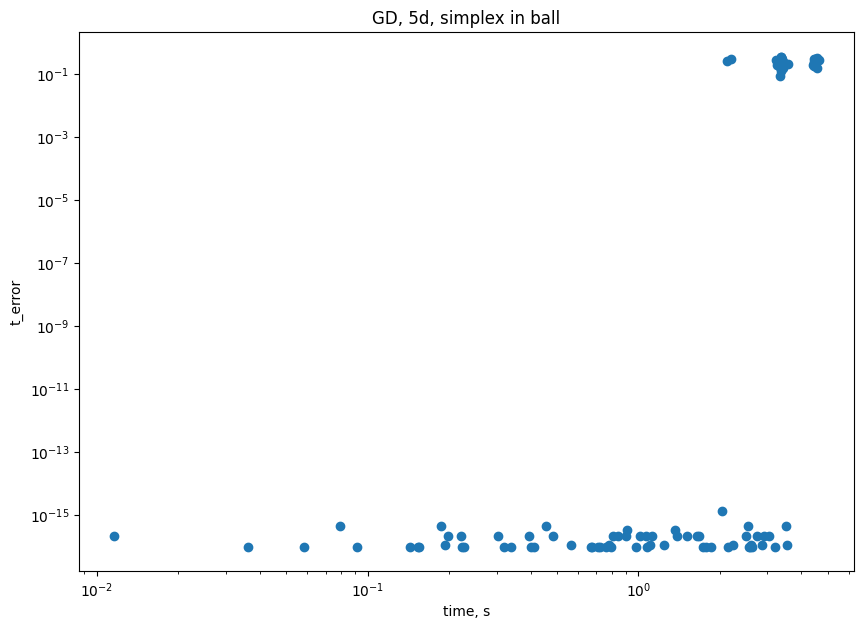

In [9]:
times_gd, errors_gd = get_gd_simplex_in_ball_results(5, silent=False)
plot_test_results(times_gd, errors_gd, 'GD, 5d, simplex in ball', fit=False)

In [ ]:
np.array([0,1,2,3])[:2]

In [ ]:
%load_ext line_profiler

In [ ]:
def get_baseline_test_results(dimension: int, number_tests: int, lowest_grid_density: float=100, highest_grid_density: float=10000,
                             silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        time, t_error = run_random_test(BaselineSolver, dimension, 
                                        {'grid_density': np.exp(np.random.uniform(np.log(lowest_grid_density), np.log(highest_grid_density)))}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [ ]:
def get_iterative_test_results(dimension: int, number_tests: int, lowest_cap_grid_diameter: int=3, 
                               highest_cap_grid_diameter: int=10,
                              silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        cap_grid_diameter = int(np.round(np.exp(np.random.uniform(np.log(lowest_cap_grid_diameter), np.log(highest_cap_grid_diameter)))))
        time, t_error = run_random_test(IterativeSolver, dimension, 
                                        {'cap_grid_diameter': cap_grid_diameter}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [ ]:
def get_greedy_simplex_in_ball_results(dimension: int, lowest_max_iteration: int=80, highest_max_iteration: int=80, 
                            silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    deltas = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b, delta = read_tests_simplex_in_ball(f'./tests/{dimension}d/simplex-in-ball/{file}', dimension)
        solver_instance = GreedySolver(dimension, support_a, support_b, 
                                 num_iterations=int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration)))))
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        deltas.append(delta)
        if not silent:
            print(f'test \t{file}\t time \t{end_time - start_time}\t t_error \t{abs(1. - solver_instance.t)}')

    return np.array(times), np.array(t_errors), np.array(deltas)

In [ ]:
def get_greedy_simplex_plus_ball_in_ball_results(dimension: int, lowest_max_iteration: int=100, highest_max_iteration: int=100, 
                            silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    deltas = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b, delta = read_tests_simplex_plus_ball_in_ball(f'./tests/{dimension}d/simplex-plus-ball-in-ball/{file}', dimension)
        solver_instance = GreedySolver(dimension, support_a, support_b, 
                                 num_iterations=int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration)))))
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        deltas.append(delta)
        if not silent:
            print(f'test \t{file}\t time \t{end_time - start_time}\t t_error \t{abs(1. - solver_instance.t)}')

    return np.array(times), np.array(t_errors), np.array(deltas)

In [ ]:
def get_greedy_degenerate_simplex_in_ball_results(dimension: int, lowest_max_iteration: int=100, highest_max_iteration: int=100, 
                            silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/simplex-in-ball/')):
        support_a, support_b = read_tests_degenerate_simplex_in_ball(f'./tests/{dimension}d/degenerate-simplex-in-ball/{file}', dimension)
        solver_instance = GreedySolver(dimension, support_a, support_b, 
                                 num_iterations=int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration)))))
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        if not silent:
            print(f'test \t{file}\t time \t{end_time - start_time}\t t_error \t{abs(1. - solver_instance.t)}')

    return np.array(times), np.array(t_errors)

In [ ]:
def get_greedy_polyhedron_in_ball_results(dimension: int, lowest_max_iteration: int=100, highest_max_iteration: int=100, 
                            silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    d = []
    for file in sorted(os.listdir(f'./tests/{dimension}d/polyhedron-in-ball/')):
        support_a, support_b, current_d = read_tests_polyhedron_in_ball(f'./tests/{dimension}d/polyhedron-in-ball/{file}', dimension)
        solver_instance = GreedySolver(dimension, support_a, support_b, 
                                 num_iterations=int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration)))))
        start_time = time.time()
        solver_instance.solve()
        end_time = time.time()
        times.append(end_time - start_time)
        t_errors.append(abs(1. - solver_instance.t))
        d.append(current_d)
        if not silent:
            print(f'test \t{file}\t time \t{end_time - start_time}\t t_error \t{abs(1. - solver_instance.t)}')

    return np.array(times), np.array(t_errors), np.array(d)

file = random.choice(os.listdir('./tests/10d/simplex-in-ball/'))
support_a, support_b, delta = read_tests_simplex_in_ball(f'./tests/10d/simplex-in-ball/{file}', 10)
solver_instance = GreedySolver(10, support_a, support_b, num_iterations=500)

%prun solver_instance.solve()

times_greedy_2d, errors_greedy_2d, d_greedy_2d = get_greedy_polyhedron_in_ball_results(2, silent=True)
plot_test_results(times_greedy_2d, errors_greedy_2d, 'GreedySolver, 2d, polyhedron in ball', fit=False, colors=d_greedy_2d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_3d, errors_greedy_3d, d_greedy_3d = get_greedy_polyhedron_in_ball_results(3, silent=True) 
plot_test_results(times_greedy_3d, errors_greedy_3d, 'GreedySolver, 3d, polyhedron in ball', fit=False, colors=d_greedy_3d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_4d, errors_greedy_4d, d_greedy_4d = get_greedy_polyhedron_in_ball_results(4, silent=True) 
plot_test_results(times_greedy_4d, errors_greedy_4d, 'GreedySolver, 4d, polyhedron in ball', fit=False, colors=d_greedy_4d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_5d, errors_greedy_5d, d_greedy_5d = get_greedy_polyhedron_in_ball_results(5, silent=True) 
plot_test_results(times_greedy_5d, errors_greedy_5d, 'GreedySolver, 5d, polyhedron in ball', fit=False, colors=d_greedy_5d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_10d, errors_greedy_10d, d_greedy_10d = get_greedy_polyhedron_in_ball_results(10, silent=False) 
plot_test_results(times_greedy_10d, errors_greedy_10d, 'GreedySolver, 10d, polyhedron in ball', fit=False, colors=d_greedy_10d, 
                  colorbar_name='minimal distance from a non-based vertex to the sphere')

times_greedy_2d, errors_greedy_2d = get_greedy_degenerate_simplex_in_ball_results(2, silent=True)
plot_test_results(times_greedy_2d, errors_greedy_2d, 'GreedySolver, 2d, degenerate simplex', fit=False)

times_greedy_3d, errors_greedy_3d = get_greedy_degenerate_simplex_in_ball_results(3, silent=True)
plot_test_results(times_greedy_3d, errors_greedy_3d, 'GreedySolver, 3d, degenerate simplex', fit=False)

times_greedy_4d, errors_greedy_4d = get_greedy_degenerate_simplex_in_ball_results(4, silent=True)
plot_test_results(times_greedy_4d, errors_greedy_4d, 'GreedySolver, 4d, degenerate simplex', fit=False)

times_greedy_5d, errors_greedy_5d = get_greedy_degenerate_simplex_in_ball_results(5, silent=True)
plot_test_results(times_greedy_5d, errors_greedy_5d, 'GreedySolver, 5d, degenerate simplex', fit=False)

times_greedy_10d, errors_greedy_10d = get_greedy_degenerate_simplex_in_ball_results(10, silent=False)
plot_test_results(times_greedy_10d, errors_greedy_10d, 'GreedySolver, 10d, degenerate simplex', fit=False)

times_greedy_2d, errors_greedy_2d, deltas_greedy_2d = get_greedy_simplex_plus_ball_in_ball_results(2, silent=True)
plot_test_results(times_greedy_2d, errors_greedy_2d, deltas_greedy_2d, 'GreedySolver, 2d, simplex + ball, 50 iterations', fit=False)

times_greedy_3d, errors_greedy_3d, deltas_greedy_3d = get_greedy_simplex_plus_ball_in_ball_results(3, silent=True)
plot_test_results(times_greedy_3d, errors_greedy_3d, deltas_greedy_3d, 'GreedySolver, 3d, simplex + ball, 50 iterations', fit=False)

times_greedy_4d, errors_greedy_4d, deltas_greedy_4d = get_greedy_simplex_plus_ball_in_ball_results(4, silent=True)
plot_test_results(times_greedy_4d, errors_greedy_4d, deltas_greedy_4d, 'GreedySolver, 4d, simplex + ball, 50 iterations', fit=False)

times_greedy_5d, errors_greedy_5d, deltas_greedy_5d = get_greedy_simplex_plus_ball_in_ball_results(5, silent=True)
plot_test_results(times_greedy_5d, errors_greedy_5d, deltas_greedy_5d, 'GreedySolver, 5d, simplex + ball, 80 iterations', fit=False)

times_greedy_10d, errors_greedy_10d, deltas_greedy_10d = get_greedy_simplex_plus_ball_in_ball_results(10, silent=False)
plot_test_results(times_greedy_10d, errors_greedy_10d, deltas_greedy_10d, 'GreedySolver, 10d, simplex + ball, 100 iterations', fit=False)

times_greedy_2d, errors_greedy_2d, deltas_greedy_2d = get_greedy_test_results(2, silent=False)
plot_test_results(times_greedy_2d, errors_greedy_2d, deltas_greedy_2d, 'GreedySolver, 2d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_greedy_3d, errors_greedy_3d, deltas_greedy_3d = get_greedy_test_results(3, silent=False)
plot_test_results(times_greedy_3d, errors_greedy_3d, deltas_greedy_3d, 'GreedySolver, 3d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_greedy_4d, errors_greedy_4d, deltas_greedy_4d = get_greedy_test_results(4, silent=False)
plot_test_results(times_greedy_4d, errors_greedy_4d, deltas_greedy_4d, 'GreedySolver, 4d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_greedy_5d, errors_greedy_5d, deltas_greedy_5d = get_greedy_test_results(5, silent=False)
plot_test_results(times_greedy_5d, errors_greedy_5d, deltas_greedy_5d, 'GreedySolver, 5d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_greedy_10d, errors_greedy_10d, deltas_greedy_10d = get_greedy_test_results(10, silent=False)
plot_test_results(times_greedy_10d, errors_greedy_10d, deltas_greedy_10d, 'GreedySolver, 10d, n(n+1) caps with heuristic, random inscribed simplex', fit=False)

times_iterative_2d, errors_iterative_2d = get_iterative_test_results(2, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_2d, errors_iterative_2d, 'IterativeSolver, 2d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_3d, errors_iterative_3d = get_iterative_test_results(3, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_3d, errors_iterative_3d, 'IterativeSolver, 3d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_4d, errors_iterative_4d = get_iterative_test_results(4, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_4d, errors_iterative_4d, 'IterativeSolver, 4d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_5d, errors_iterative_5d = get_iterative_test_results(5, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_5d, errors_iterative_5d, 'IterativeSolver, 5d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_baseline_2d, errors_baseline_2d = get_baseline_test_results(2, 1000)

plot_test_results(times_baseline_2d, errors_baseline_2d, 'BaselineSolver, 2d, grid_from_cube, random inscribed simplex')

times_baseline_3d, errors_baseline_3d = get_baseline_test_results(3, 1000)

plot_test_results(times_baseline_3d, errors_baseline_3d, 'BaselineSolver, 3d, grid_from_cube, random inscribed simplex')

times_baseline_4d, errors_baseline_4d = get_baseline_test_results(4, 1000)

plot_test_results(times_baseline_4d, errors_baseline_4d, 'BaselineSolver, 4d, grid_from_cube, random inscribed simplex')

times_baseline_5d, errors_baseline_5d = get_baseline_test_results(5, 1000)

plot_test_results(times_baseline_5d, errors_baseline_5d, 'BaselineSolver, 5d, grid_from_cube, random inscribed simplex')